# Julia Fractals

The following is a comprehensive introduction to Julia Sets and how to manage them with DataJoint.

## Historical Background

Julia sets are captivating fractal images discovered independently by the French mathematicians **Gaston Julia** and **Pierre Fatou** in the early 20th century. Gaston Julia published his groundbreaking work on what we now call Julia sets in 1918, at the age of 25, despite having lost his nose in World War I and wearing a leather strap across his face. This research was largely theoretical and difficult to visualize until the advent of modern computers.

The set was named after Gaston Julia, who published his now-famous paper "Mémoire sur l'itération des fonctions rationnelles" in 1918. However, it wasn't until Benoit Mandelbrot (who later created the famous Mandelbrot set) worked at IBM in the 1970s and 1980s that these fractals could be properly visualized using computer graphics. The connection between the Mandelbrot set and all Julia sets was a crucial discovery—each point in the Mandelbrot set corresponds to a unique Julia set.

## What are Julia Fractals?

Julia sets are generated by iterating complex functions, typically the quadratic function $f_c(z) = z^2 + c$, where both $z$ and $c$ are complex numbers. For a given complex parameter $c$, the Julia set $J_c$ is the boundary between two types of behavior:

1. **Points that remain bounded** under iteration of $f_c$
2. **Points that escape to infinity** under iteration

The visual representation of a Julia set shows beautiful, intricate fractal patterns with astonishing self-similarity—the same patterns appear at every scale. These fractals are not just mathematical curiosities; they appear throughout nature in phenomena like turbulence, coastlines, and biological growth patterns.

## How They Are Generated

The algorithm for generating Julia fractals (as implemented below) works by:
1. Testing each point in the complex plane to see how it behaves under repeated iteration
2. Counting how many iterations it takes for the point to "escape" (grow larger than 2 in magnitude)
3. Coloring the point based on this iteration count

Each different value of $c$ produces a completely different fractal pattern—some connected, some fragmented into dust-like structures. Small changes to $c$ can produce dramatically different images, making exploration of the parameter space endlessly fascinating.

## The Julia Generation Algorithm

The function below implements the standard algorithm for generating Julia sets (this will later be used by our DataJoint computed tables). Here's how it works:

1. **Create a grid** of complex numbers covering a region of the complex plane
2. **Iterate each point** through the function $f_c(z) = z^2 + c$ many times
3. **Track escape time**: Points that remain bounded add to the iteration count, points that escape (when $|z| > 2$) stop contributing
4. **Create the image**: The iteration counts create the characteristic fractal patterns

The parameters control different aspects:
- `c`: The complex parameter (different values create wildly different fractals)
- `size`: Resolution of the resulting image
- `center`: Where to look in the complex plane
- `zoom`: How much to zoom in (larger = more detailed, narrower region)
- `iters`: Maximum number of iterations (more = finer detail but slower)

The resulting image shows how quickly different regions of the complex plane "escape" under iteration, creating the beautiful fractal boundaries we see in Julia sets.


In [24]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import datajoint as dj

In [25]:
def julia(c, size=256, center=(0.0, 0.0), zoom=1.0, iters=256):
    x, y = np.meshgrid(
        np.linspace(-1, 1, size)/zoom + center[0], 
        np.linspace(-1, 1, size)/zoom + center[1], 
    )
    z = x + 1j * y
    im = np.zeros(z.shape)
    ix = np.ones(z.shape, dtype=bool)
    for i in range(iters):
        z[ix] = z[ix] ** 2 + c
        ix = np.abs(z) < 2
        im += ix
    return im

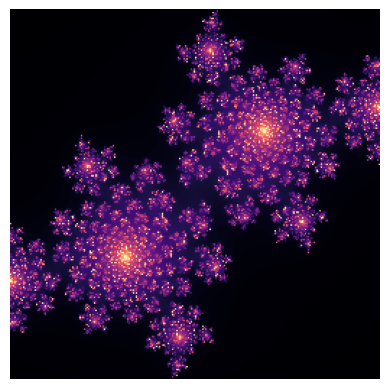

In [26]:
plt.imshow(julia(-0.4+0.6j), cmap='magma')
plt.axis(False);

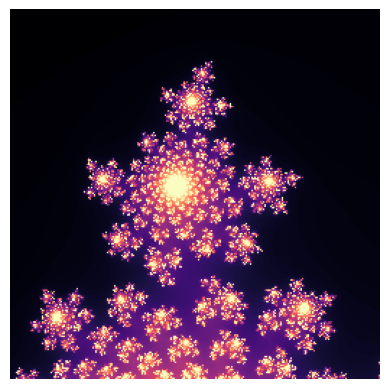

In [27]:
plt.imshow(julia(-0.4+0.6j, center=(0.34, -0.30), zoom=10000.0), cmap='magma')
plt.axis(False);

In [28]:
c = (
    -0.4 + 0.6j, 
    -0.74543 + 0.11301j, 
    -0.75 + 0.11j, 
    -0.1 + 0.651j,
    -0.835 - 0.2321j,
    -0.70176 - 0.3842j,
)

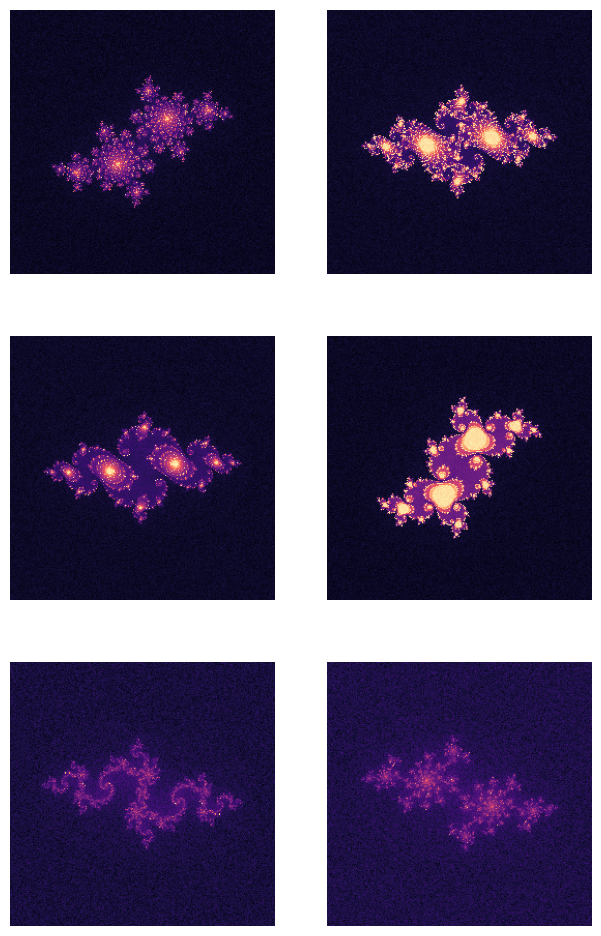

In [29]:
noise_level = 5.0

fig, ax = plt.subplots(3, 2, figsize=(7.5, 12))
for c_, a in zip(c, ax.flatten()):
    img = julia(c_, zoom=0.5) 
    img += np.random.randn(*img.shape) * noise_level
    a.imshow(img, cmap='magma')
    a.axis(False)

## Image Processing: Denoising Fractals

In real-world applications, data acquisition often involves noisy data. While we're adding noise artificially here for demonstration, similar challenges arise when:

- Processing images from telescopes or microscopes
- Analyzing scientific data with measurement errors
- Working with sensor data that has inherent noise

We'll apply several different denoising techniques to see how they handle fractal images:

1. **Gaussian filtering**: Smooths images using a bell-shaped kernel, good for Gaussian noise
2. **Median filtering**: Replaces each pixel with the median of its neighbors, excellent for salt-and-pepper noise
3. **Total Variation (TV) denoising**: Preserves edges while removing noise, based on the assumption that real images have bounded variation
4. **Wavelet denoising**: Works in the frequency domain, preserving features at different scales

Each method has strengths and weaknesses. For fractal images with their intricate edge structures, preserving boundaries while removing noise is particularly challenging—a task that real scientific imaging often faces.

In [30]:
from skimage import data
from skimage import filters
from skimage.morphology import disk
from skimage import restoration

In [31]:
noise_level = 50.0
img = julia(-0.4+0.6j, size=200)
noise_img = img + np.random.randn(*img.shape) * noise_level
median_img = filters.median(noise_img, disk(3))
tv_img = restoration.denoise_tv_chambolle(noise_img, weight=20.0)
wavelet_img = restoration.denoise_wavelet(noise_img)
gaussian_img = filters.gaussian(noise_img, sigma=1.8)

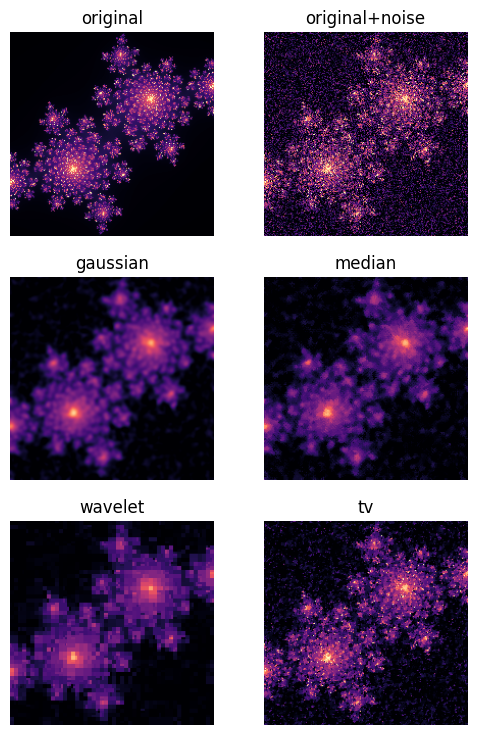

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(6, 9))
for a, (im, title) in zip(
    ax.flatten(),
    ((img, 'original'), 
     (noise_img, 'original+noise'),
     (gaussian_img, 'gaussian'),
     (median_img, 'median'), 
     (wavelet_img, 'wavelet'),
     (tv_img, 'tv'), )):
    a.imshow(im, cmap='magma', vmin=0, vmax=255)
    a.axis(False)
    a.set_title(title)

## DataJoint Pipeline for Julia Fractals

Now let's build a comprehensive data pipeline to manage Julia sets and their analysis using DataJoint. This demonstrates how to structure a scientific workflow that tracks:

1. **Experimental parameters**: The configurations used to generate different fractals
2. **Generated images**: The actual Julia set images computed from those parameters
3. **Processing pipelines**: Multiple image processing approaches applied to each image

### Pipeline Architecture

Our DataJoint pipeline consists of three main components and demonstrates different DataJoint table types:

**Understanding Table Types in DataJoint:**
- **Manual tables**: Empty by default, require explicit insertions. Use for experimental parameters, user inputs, or data that's added incrementally.
- **Lookup tables**: Have predefined contents loaded automatically. Use for fixed reference data like standard methods, units, or categorical options.
- **Computed tables**: Automatically generated from their dependencies via a `make()` method when `populate()` is called. Use for derived data, processed results, or computed outputs.

We'll see all three types in action below!

#### 1. `JuliaSpec` (Manual Table)
This table stores the parameters that define each unique Julia fractal we want to generate:
- `creal`, `cimag`: The complex parameter c (real and imaginary parts)
- `size`: Image resolution
- `center_real`, `center_imag`: Where to focus in the complex plane
- `zoom`: Zoom level
- `noise_level`: Amount of noise to add

This is a **Manual table** because we manually populate it with different experimental configurations using `insert()` calls. Unlike Lookup tables (which have predefined contents), Manual tables have no default data and require explicit insertion of all entries.

**Manual vs Lookup Tables**: The key distinction is that Manual tables have no predefined data and all entries must be explicitly inserted, while Lookup tables include pre-populated default entries that are automatically loaded when the table is created. We use Manual here because we want to add experimental configurations one by one rather than having a fixed set from the start.

#### 2. `JuliaImage` (Computed Table)
This table automatically generates Julia fractal images based on the specifications in `JuliaSpec`. It's a **Computed table** because:
- It depends on `JuliaSpec` via the relationship `-> JuliaSpec`
- It automatically computes missing results when `populate()` is called
- It stores the generated images in the database

The `make` method implements the generation logic using our `julia()` function.

#### 3. `JuliaDenoised` (Computed Table)
This table applies various denoising algorithms to the noisy Julia images. It depends on **both** `JuliaImage` and `DenoiseMethod` (which stores the different denoising algorithms), creating a many-to-many relationship where each image gets processed by each denoising method.

### Pipeline Execution Flow

The typical workflow is:
1. **Define specifications**: Insert parameters into `JuliaSpec`
2. **Generate fractals**: Call `JuliaImage.populate()` to automatically generate all missing images
3. **Define processing methods**: Create `DenoiseMethod` entries for each denoising algorithm
4. **Process images**: Call `JuliaDenoised.populate()` to apply all methods to all images
5. **Query results**: Use DataJoint's query syntax to retrieve and analyze specific results

This automatic, reproducible pipeline ensures that:
- No results are lost or forgotten
- Processing is reproducible
- Results are easily queryable and traceable back to their parameters
- The dependency graph is clear and enforced by the database

Let's build this pipeline step by step!

In [33]:
import datajoint as dj

schema = dj.Schema('julia')

In [34]:
@schema 
class JuliaSpec(dj.Manual):
    definition = """
    julia_spec : smallint 
    ---
    creal : float
    cimag : float
    size=256 : smallint
    center_real=0.0 : float 
    center_imag=0.0 : float
    zoom=1.0 : float
    noise_level=50 : float
    """  


In [35]:
JuliaSpec.insert(
    (
        dict(julia_spec=0, creal=-0.4, cimag=0.6, noise_level=50),
        dict(julia_spec=1, creal=-0.7453, cimag=0.11301, noise_level=50),
        dict(julia_spec=2, creal=-0.75, cimag=0.11, noise_level=50),
        dict(julia_spec=3, creal=-0.1, cimag=0.651, noise_level=50),
        dict(julia_spec=4, creal=-0.835, cimag=-0.2321, noise_level=50),
        dict(julia_spec=5, creal=-0.70176, cimag=-0.3842, noise_level=50),
    )
)

In [36]:
JuliaSpec.insert1(
    dict(julia_spec=10, 
         creal=-0.4, cimag=0.6, 
         center_real=0.34, center_imag=-0.30, 
         zoom=10000.0, 
         noise_level=50.0)
)  

In [37]:
@schema
class JuliaImage(dj.Computed):
    definition = """
    -> JuliaSpec 
    ---
    image : longblob
    """

    def make(self, key):
        spec = (JuliaSpec & key).fetch1()
        img = julia(spec['creal'] + 1j*spec['cimag'], 
                    size=spec['size'],
                    center=(spec['center_real'], spec['center_imag']),
                    zoom=spec['zoom'],
                    )
        img += np.random.randn(*img.shape) * spec['noise_level']
        self.insert1(dict(key, image=img.astype(np.float32)))

### Understanding the Pipeline in Action

Let's see how the DataJoint pipeline executes:

**Step 1: JuliaSpec Definition**
The `JuliaSpec` table is a **Manual table**, which means it has no predefined contents and all entries must be explicitly inserted. Notice how we use `JuliaSpec.insert()` to add entries one by one. This gives us flexibility to add experimental configurations as needed, rather than having a fixed set of predefined options like a Lookup table would have.

**Distinction: Manual vs Lookup**
- **Manual tables** (`dj.Manual`): Empty by default, require explicit `insert()` calls for every entry. Perfect for experimental data or user-entered configurations.
- **Lookup tables** (`dj.Lookup`): Have predefined contents specified in the `contents` attribute. Automatically populated when the table is created. Perfect for fixed reference data like units of measurement or standard algorithms.

In our case, we use Manual for `JuliaSpec` because we want to add different fractal configurations incrementally, testing new parameter combinations as we explore the space.

**Step 2: Generating Images**
When we call `JuliaImage.populate()`, DataJoint:
- Scans `JuliaSpec` for all entries
- Checks which entries don't have corresponding `JuliaImage` entries
- For each missing entry, calls the `make()` method
- The `make()` method fetches the specification, generates the fractal, and stores it

The `@schema` decorator connects these classes to our database schema, ensuring all operations are tracked and persisted.


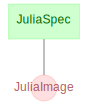

In [38]:
dj.Diagram(schema)

In [39]:
JuliaImage.populate(display_progress=True)

JuliaImage: 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]


{'success_count': 7, 'error_list': []}

In [40]:
JuliaImage()

julia_spec,image
0,=BLOB=
1,=BLOB=
2,=BLOB=
3,=BLOB=
4,=BLOB=
5,=BLOB=
10,=BLOB=


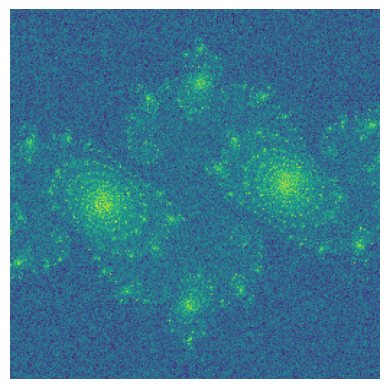

In [41]:
plt.imshow((JuliaImage & 'julia_spec=2').fetch1('image'))
plt.axis(False);

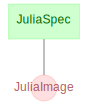

In [42]:
dj.Diagram(schema)

### Extending the Pipeline with Denoising

Now we extend our pipeline to apply multiple denoising methods:

**DenoiseMethod Table**: A **Lookup table** (in contrast to `JuliaSpec` which is Manual). Notice how it uses `contents = (...)` to define the four standard denoising methods upfront. These entries are automatically populated when the table is created, no explicit `insert()` calls needed. This is the right choice here because we have a fixed set of standard denoising algorithms we always want to apply. Each entry contains:
- The method name (gaussian, median, wavelet, tv)
- Method-specific parameters

**JuliaDenoised Table**: A computed table that creates a many-to-many relationship:
- Each noisy Julia image from `JuliaImage`
- Gets processed by each method in `DenoiseMethod`
- Produces 4 denoised versions (one per method)

This creates a systematic comparison of denoising approaches. When we call `JuliaDenoised.populate()`, DataJoint automatically generates all combinations of (image × method), ensuring we have a complete comparison dataset. This is powerful because:
- We can systematically explore parameter spaces
- All results are stored and retrievable
- We can add new images or methods without re-processing everything
- The dependency structure is enforced by the database schema

The `diagram()` calls show the evolving schema structure as we add tables and dependencies.


In [ ]:
@schema
class DenoiseMethod(dj.Lookup):
    definition = """
    denoise_method : smallint
    ---
    method : varchar(16)
    params=null : blob
    """
    contents = (
        (0, 'gaussian', dict(sigma=1.8)),
        (1, 'median', dict(radius=3)),
        (2, 'wavelet', {}),
        (3, 'tv', dict(weight=20.0))
    )

In [44]:
@schema 
class JuliaDenoised(dj.Computed):
    definition = """
    -> JuliaImage
    -> DenoiseMethod
    ---
    denoised_image : longblob
    """

    def make(self, key):
        img = (JuliaImage & key).fetch1('image')
        method, params = (DenoiseMethod & key).fetch1('method', 'params')

        if method == "gaussian":
            result = filters.gaussian(img, **params)
        elif method == "median":
            result = filters.median(img, disk(params['radius']))
        elif method == 'tv':
            result = restoration.denoise_tv_chambolle(img, **params)
        elif method == "wavelet":
            result = restoration.denoise_wavelet(noise_img, **params)
        else:
            raise NotImplementedError
        self.insert1(dict(key, denoised_image=result))

In [45]:
JuliaDenoised.populate(display_progress=True)

JuliaDenoised:   0%|          | 0/28 [00:00<?, ?it/s]

JuliaDenoised: 100%|██████████| 28/28 [00:00<00:00, 37.34it/s]


{'success_count': 28, 'error_list': []}

In [46]:
JuliaDenoised()

julia_spec,denoise_method,denoised_image
0,0,=BLOB=
0,1,=BLOB=
0,2,=BLOB=
0,3,=BLOB=
1,0,=BLOB=
1,1,=BLOB=
1,2,=BLOB=
1,3,=BLOB=
2,0,=BLOB=
2,1,=BLOB=


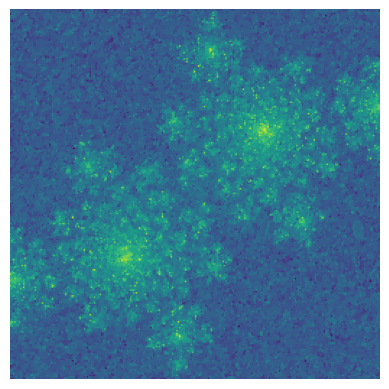

In [47]:
keys = JuliaDenoised.fetch('KEY')
img = ((JuliaDenoised & keys[21])).fetch1('denoised_image')
plt.imshow(img)
plt.axis(False);

## Summary: DataJoint Table Types in Action

We've demonstrated all three main DataJoint table types:

| Table Type | Example | Purpose | Population |
|------------|---------|---------|------------|
| **Manual** | `JuliaSpec` | Experimental parameters | Requires explicit `insert()` calls |
| **Lookup** | `DenoiseMethod` | Fixed reference data | Automatic from `contents` |
| **Computed** | `JuliaImage`, `JuliaDenoised` | Derived data | Automatic via `make()` when `populate()` is called |

**Key takeaway**: The choice between Manual and Lookup depends on whether your data is known upfront (Lookup) or added incrementally during experiments (Manual). Both feed into Computed tables that automatically generate results based on dependencies.

This design enforces reproducibility: every result can be traced back through its dependencies to the original experimental parameters!


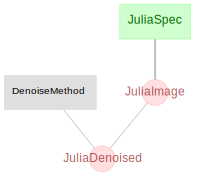

In [ ]:
dj.Diagram(schema)